# LIME

https://github.com/marcotcr/lime

In [1]:
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

from sklearn.datasets import load_wine, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import accuracy_score

from lime.lime_tabular import LimeTabularExplainer

RANDOM_STATE = 0

## Dataset

In [2]:
wine = load_wine()
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

## Utils

In [3]:
def ascat(y_num):
    y_num = np.array(y_num)
    return np.vectorize(wine.target_names.__getitem__)(y_num.ravel()).reshape(y_num.shape)

CAT2NUM = {c: i for i, c in enumerate(wine.target_names)}

def asnum(y_cat):
    y_cat = np.array(y_cat)
    return np.vectorize(CAT2NUM.get)(y_cat.ravel()).reshape(y_cat.shape)

## Task 1: PCA 2D

Pick the right value for the `test_size` and visualize the wine dataset using `sklearn.decomposition.PCA()`. Make sure to fit the PCA only on the test part of the dataset - no cheating! Leave the commented code untouched.

In [4]:
X = wine.data
y = ascat(wine.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# ss = StandardScaler()
# X_train = ss.fit_transform(X_train)
# X_test = ss.transform(X_test)

X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))
split = np.array(['train'] * len(X_train) + ['test'] * len(X_test))

In [5]:
pca2 = PCA(n_components=2)
X_train2 = pca2.fit_transform(X_train)
X_test2 = pca2.transform(X_test)
X_pca2 = np.vstack((X_train2, X_test2))

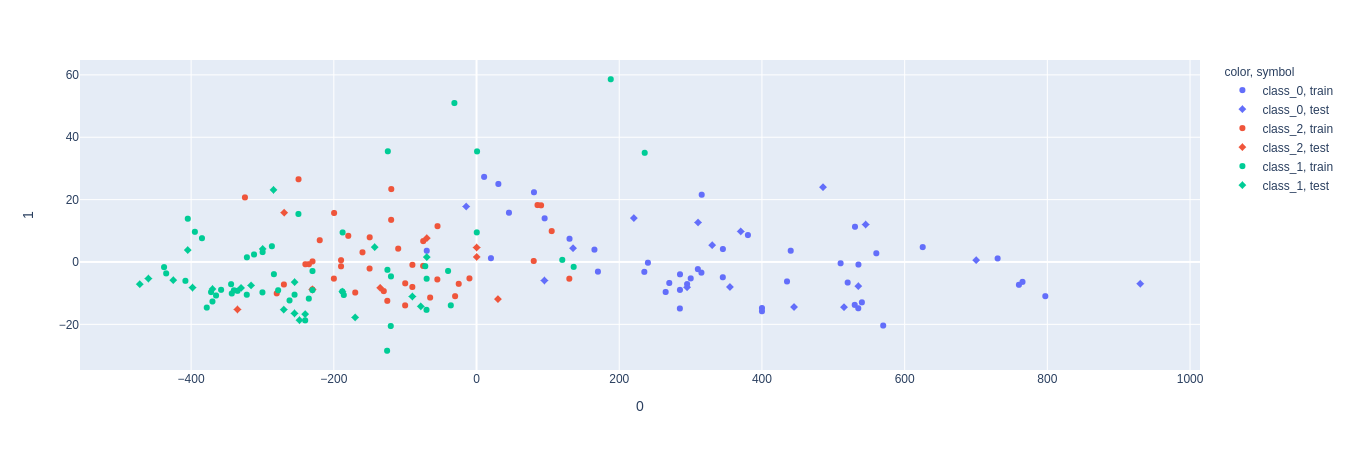

In [6]:
px.scatter(X_pca2, 0, 1, y, split)

## Task 1 bonus: PCA 3D - because `plotly.express` is quite awesome

Do the same as before, but for 3D PCA. Params for `px.scatter_3d()` follow the same pattern as for `px.scatter()`.

In [7]:
pca3 = PCA(n_components=3)
X_train3 = pca3.fit_transform(X_train)
X_test3 = pca3.transform(X_test)
X_pca3 = np.vstack((X_train3, X_test3))

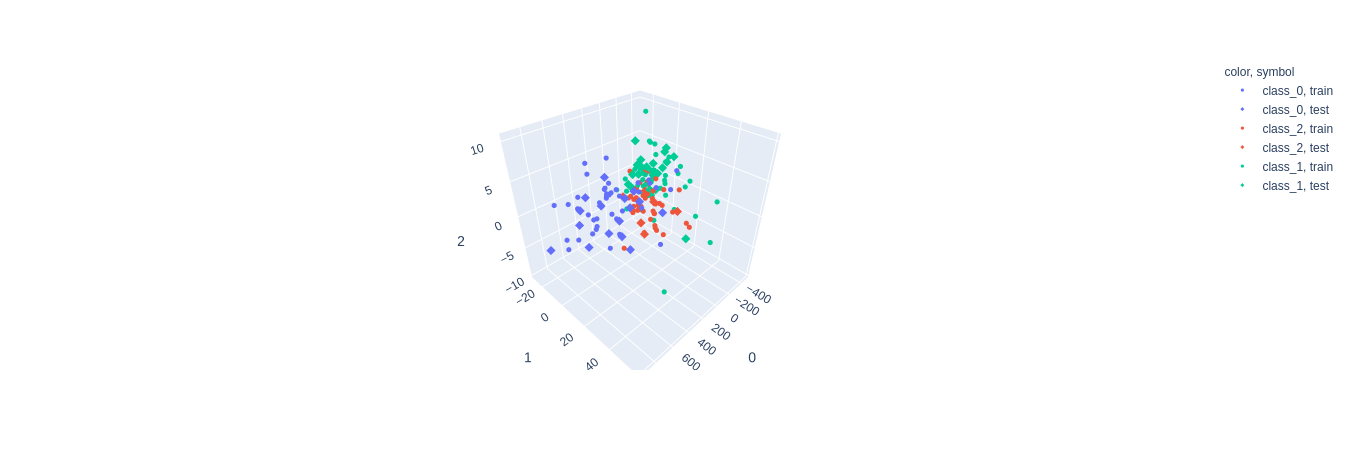

In [8]:
fig = px.scatter_3d(X_pca3, 0, 1, 2, y, split)
fig.update_traces(marker=dict(size=3))

## Task 2: Model

We will explain a classifier based on Support Vector Machine. Train the `sklearn.svm.SVC` classifier by picking any kernel you like and check the `sklearn.metrics.accuracy_score` on the test set and on the whole dataset. Training should be fast, so that you can experiment. We don't need to optimize for accuracy, we're only interested in explaining how a given classifier works inside.

In [9]:
svc = SVC(kernel='rbf', probability=True)
svc.fit(X_train, y_train)
accuracy_score(y_test, svc.predict(X_test))

0.8222222222222222

In [10]:
y_pred = svc.predict(X)
accuracy_score(y, svc.predict(X))

0.7303370786516854

## Task 3: Visualizing decision boundaries

We will evaluate our trained classifier on a rectangular mesh of points to probe classifier decisions on the whole PCA 2D parameter space.

### Task 3a: Mesh

Create a uniformly spaced range of coordinates for points in both dimensions. Use `min`, `max` and `h` variables to set start, end and step size for each dimension.

In [11]:
padding = 1.25
num = 200

x0_min = X_pca2[:, 0].min() * padding
x0_max = X_pca2[:, 0].max() * padding
h0 = (x0_max - x0_min) / num

x1_min = X_pca2[:, 1].min() * padding
x1_max = X_pca2[:, 1].max() * padding
h1 = (x1_max - x1_min) / num

x0s = np.arange(x0_min, x0_max, h0)
x1s = np.arange(x1_min, x1_max, h1)

mesh_pca2 = np.meshgrid(x0s, x1s)
np.array(mesh_pca2).shape

(2, 200, 200)

### Task 3b: Projection

Coordinates are used to generate a mesh, but it is in a 2D PCA coordinate space. To evaluate classifier we need to project the PCAd mesh into the original parameter space. Use the `pca2` instance fit beforehand to do just that. Everything should be ok if the `svc` prediction works.

In [12]:
mesh_pca2 = np.array(mesh_pca2).reshape(2, num**2).T # this has a shape: (num*num, 2)
mesh = pca2.inverse_transform(mesh_pca2) # this should have a shape: (num*num, 13)
y_mesh = svc.predict(mesh).reshape(num, num)

### Task 3c: Visualization

Examine the plot. Afterwards, modify `hove_data`, so that each point has its index in `X_pca2` displayed on hover. This will help in finding points to investigate the classifier at. Choose a point of interest to explain in a cell under the plot and verify that its coordinates match the plot. How is the POI classified, what are the probabilities of belonging to each class?

In [13]:
def plot_decision_boundaries():
    fig = px.scatter(
        X_pca2,
        x=0,
        y=1,
        color=y,
        symbol=y_pred,
        size=[1 if yt == yp else 3 for yt, yp in zip(y, y_pred)],
        size_max=6,
        hover_data={
            'index': [0] * len(X_pca2) # range(len(X_pca2))
        },
    )
    fig.add_trace(
        go.Heatmap(
            x=x0s,
            y=x1s,
            z=asnum(y_mesh),
            zmin=0,
            zmax=2,
            opacity=0.5,
            colorscale=[[0, '#636efa'], [1/3, '#636efa'], [1/3, '#00cc96'], [2/3, '#00cc96'], [2/3, '#EF553B'], [1, '#EF553B']],
            showscale=False,
            hoverinfo='skip',
        ),
    )
    fig.layout.legend.title = 'color, symbol == y_true, y_pred'
    return fig

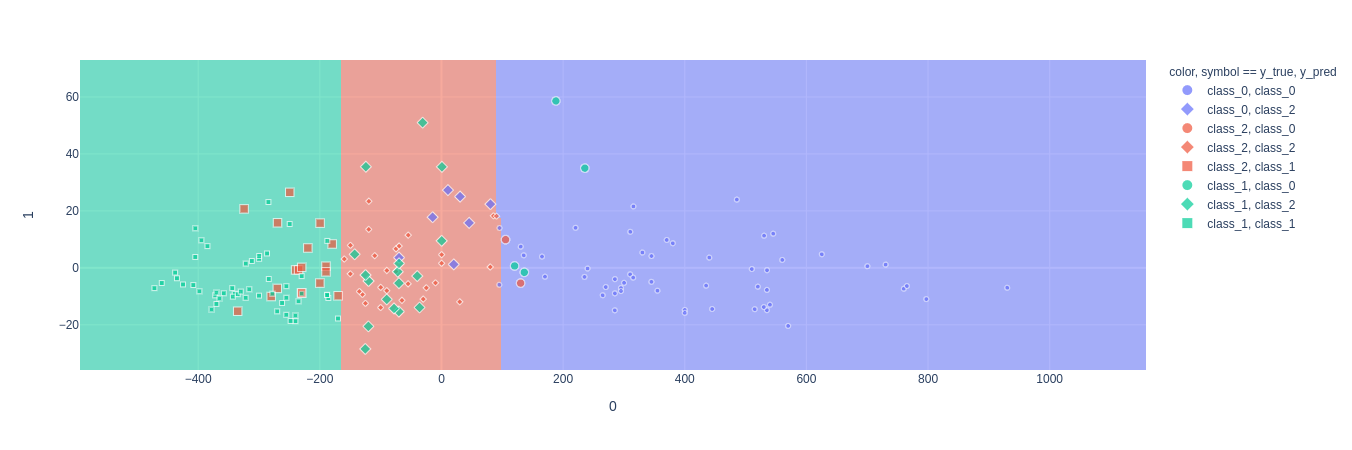

In [14]:
plot_decision_boundaries()

In [15]:
poi = X[65]
display(
    pca2.transform([poi]),
    svc.predict([poi]),
    svc.predict_proba([poi])
)

array([[-119.45469612,   23.37525906]])

array(['class_2'], dtype='<U7')

array([[0.04789531, 0.54783551, 0.40426918]])

### Task 4: Explanation

We will try to explain the chosen point of interest by generating a blob of probe points around it and fitting a linear regression `Y = AX + B`, where `Y` are the probabilities returned by our classifier on probe points and `X` are the probe points' coordinates.

### Task 4a: Blob

Generate a blob centered at `0.0` with an isotropic standard deviation of `1.0`. The blob will be automatically rescaled with an std of the train dataset and its mean moved to POI.

In [16]:
blob, *_ = make_blobs(
    n_samples=1000,
    n_features=X.shape[1],
    centers=[np.zeros_like(poi)],
    cluster_std=1.0,
    random_state=RANDOM_STATE,
)
blob_scaler = StandardScaler(with_mean=False).fit(X_train)
blob = blob * blob_scaler.scale_ + poi
blob = np.vstack([poi, blob])
blob_pca2 = pca2.transform(blob)

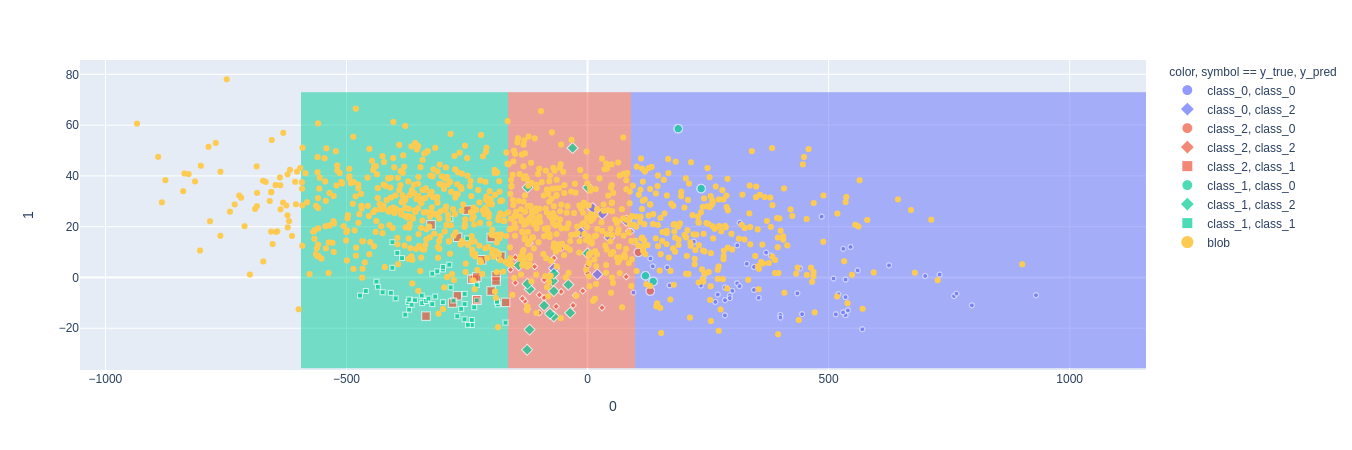

In [17]:
plot_decision_boundaries().add_trace(go.Scatter(x=blob_pca2[:, 0], y=blob_pca2[:, 1], name='blob', mode='markers'))

### Task 4b: Probe Weights

We're explaining the POI at the center of our blob and the further we are from the POI, the less relevant probe points are. We need to weigh them accordingly. Implement the Mahalanobis distance (data dimensions normalized by their std) and $e^{-x^2}$ kernel. Blob weights should be well dispersed across a range of orders of magnitude.

Asuming dimensions are independent variables, Mahalanobis distance is:
$$d(\vec{x}, \vec{y}) = \sqrt{\sum_{i = 1}^{N} \frac{(x_i - y_i)^2}{s_i^2}}$$

In [18]:
def mahalanobis(a, b, std):
    d = np.atleast_2d((a - b) / std)
    return np.sqrt(np.sum(d**2))

def kernel(d):
    return np.exp(-d**2)

In [19]:
blob_weights = [kernel(mahalanobis(poi, b, blob_scaler.scale_)) for b in blob]
blob_weights

[1.0,
 2.889423368624428e-09,
 1.2823616587446455e-05,
 1.979142674751339e-05,
 1.5851852670092489e-06,
 6.151195538824777e-08,
 1.6950176023854332e-09,
 9.230712132526628e-07,
 5.923048538302991e-08,
 1.2259897036659641e-05,
 4.1618478700612624e-08,
 2.8031298499667857e-06,
 8.916647891442068e-07,
 5.306112125211661e-06,
 6.0329414539142465e-05,
 0.0003564626304074918,
 8.514902267061873e-06,
 3.6406327922231493e-05,
 8.279735675796705e-08,
 0.0005127001267669761,
 4.063914723882587e-08,
 9.67336681982711e-08,
 2.584142899313899e-09,
 4.659316367547426e-08,
 0.001322807320746423,
 4.976794338894122e-07,
 0.0018541325010971014,
 4.545377130256898e-06,
 1.6962302969171037e-05,
 4.041571644424095e-07,
 0.0001497851958331935,
 1.421579236903068e-06,
 1.25876610672916e-06,
 3.3901211067497206e-05,
 0.0005982515890604482,
 0.067108608474895,
 2.4147550323261336e-11,
 6.584575913026212e-10,
 0.004396918043669488,
 0.0023005004201636435,
 1.3673449062570482e-05,
 2.5416520493528347e-06,
 0.00

### Task 4c: Regression and explanation

Choose `Lasso()` or `Ridge()` from `sklearn.linear_model` to fit the regression. Choose regularization strength such that the explanation prediction for POI is close to the original classifier prediciton, while the weights in `explanation.coef_` are sifted. The coef weights are visualized on the bar plot below. Regularization strength is too low when most variables have comparable coefs. Regularization strength is ok when there are only a few most dominant coefs left; though mind the explanation prediction.

In [20]:
blob_proba = svc.predict_proba(blob)
explanation = Lasso(0.01).fit(blob, blob_proba, sample_weight=blob_weights)

In [21]:
explanation.predict([poi])

array([[0.08421618, 0.52200956, 0.39402016]])

In [22]:
svc.predict_proba([poi])

array([[0.04789531, 0.54783551, 0.40426918]])

In [23]:
explanation.intercept_

array([-0.65706116,  0.90501487,  0.73263774])

In [24]:
explanation.coef_

array([[ 0.        ,  0.        , -0.        ,  0.        ,  0.00036802,
        -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        -0.        , -0.        ,  0.00110536],
       [-0.        , -0.        ,  0.        , -0.        , -0.00020868,
         0.        ,  0.        ,  0.        , -0.        , -0.        ,
         0.        ,  0.        , -0.00056753],
       [ 0.        , -0.        ,  0.        ,  0.        , -0.        ,
         0.        ,  0.        ,  0.        , -0.        , -0.        ,
         0.        ,  0.        , -0.00053749]])

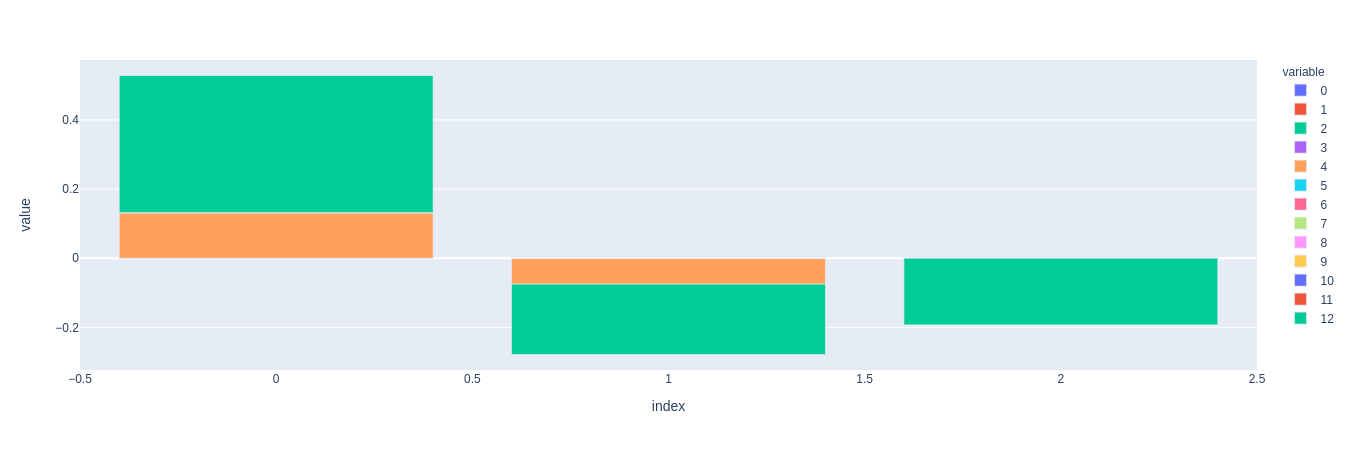

In [25]:
px.bar(explanation.coef_ / np.abs(explanation.coef_).sum())

### Task 4d: Explanation Decision Boundary

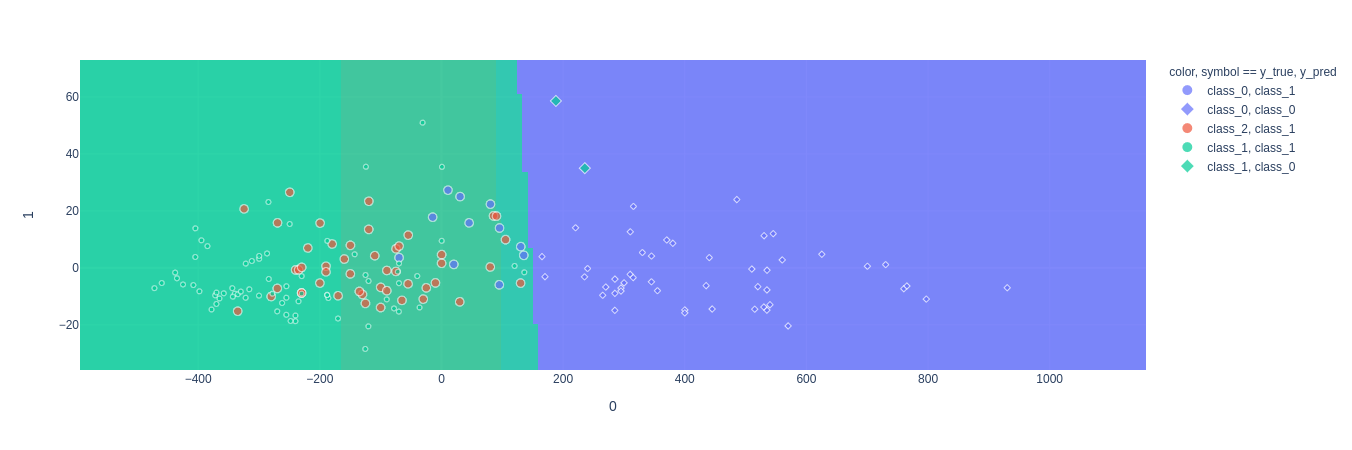

In [26]:
fig = px.scatter(
    X_pca2,
    x=0,
    y=1,
    color=y,
    symbol=ascat(explanation.predict(X).argmax(-1)),
    size=[1 if yt == yp else 3 for yt, yp in zip(y, ascat(explanation.predict(X).argmax(-1)))],
    size_max=6,
    hover_data={
        'index': range(len(X_pca2)),
    },
)
fig.add_traces([
    go.Heatmap(
        x=x0s,
        y=x1s,
        z=explanation.predict(mesh).argmax(-1).reshape(num, num),
        opacity=0.8,
        colorscale=[[0, '#636efa'], [1/3, '#636efa'], [1/3, '#00cc96'], [2/3, '#00cc96'], [2/3, '#EF553B'], [1, '#EF553B']],
        showscale=False,
        hoverinfo='skip',
        zmin=0,
        zmax=2,
    ),
    go.Heatmap(
        x=x0s,
        y=x1s,
        z=asnum(y_mesh),
        zmin=0,
        zmax=2,
        opacity=0.1,
        colorscale=[[0, '#636efa'], [1/3, '#636efa'], [1/3, '#00cc96'], [2/3, '#00cc96'], [2/3, '#EF553B'], [1, '#EF553B']],
        showscale=False,
        hoverinfo='skip',
    ),
])
fig.layout.legend.title = 'color, symbol == y_true, y_pred'
fig.show()

### Task 4e: LIME

Plug the training dataset, POI and classifier into LIME and compare the results.

In [27]:
xpl = LimeTabularExplainer(X_train, discretize_continuous=False, sample_around_instance=True)
ntn = xpl.explain_instance(data_row=poi, predict_fn=svc.predict_proba)

In [28]:
ntn.local_pred # counterpart of our explanation.predict() for the most fitting class

array([0.42535428])

In [29]:
ntn.intercept # our intercept

{1: 0.38166574724887375}

In [30]:
ntn.local_exp # our coefs

{1: [(12, -0.1377294631546881),
  (1, 0.002481874633703009),
  (11, 0.002264089191247945),
  (2, -0.0021816258671893364),
  (8, 0.0020378401235985385),
  (9, 0.0016148554169567349),
  (0, -0.0015950520362505037),
  (5, 0.00141225371814759),
  (4, -0.0003947253402575145),
  (3, -0.00022141578731159876)]}

In [31]:
ntn.show_in_notebook()